# South Park network analysis
South park is an animated sitcom created by Trey Parker and Matt Stone. The Show debuted on August 13, 1997 and there has been produced 23 seasons and 2 specials since. South Park is about the 4 friends, Eric Cartman, Stan Marsh, Kyle Broflovski and Kenny McCormick. The show is characterized by having many odd and improbable characters that is both made up, but also includes parodies of celebrities and public figures. The show often involves with controversy and taboo subjects. 

### Our inspiration
South park is a tv show that has existed as long as we can remember, we have therefore grown up with it. South park has a tendency to make shock value humor which speaks to a lot of young people. The fuck everything kind of mentality is excatly what we find fun and entertaining. The show has evolved through the years, we therefore thought it would be interesting to dig into how the characters interlink with each other and how the language has changed thorugh the seasons. 

### Goal for the project 
This notebook will give an introduction to the south park network. It will look at how characters interlink with each other and show stats from the network. It consists of commentary and explanations of the analysis. The analysis will be on basic stats, but will also dig into sentiment analysis of the main characters and how their language evolve through the seasons. The characters categories, which appear on the wiki page, will also be investigated to see if they correspond to the communities that can be found from the GCC. 


# Basic stats 
The dataset is from southpark.fandom.com where we download all character pages and episode scripts. A character link to anoher character if the other character is mentioned in its character page. This way a digraph can be created for characters that interact with each other.
A csv file called "characters.csv" has been created. The csv has a column wit the character name and another column with a list containing the characters that the character link to. The directed network has been created and the gcc has been found. Both of them are saved in the github as a pickle file. We will look at the undirected gcc which is also saved in the github as a pickle file. 

### Getting the data and cleaning

First we needed to get all the characters from the show. Looking at the characters page of the fandom wiki we noticed that all character names/pages are reffered the same way by having `[[character name]]`. This made for a simple regular expression to get all of these and then removing the '[' and ']'.  
The regular expression looks like the following:  
`'\[\[[a-zA-Z0-9\'\\ -.]*\]\]'`  
This simply states that we get a word or multiple inside double square brackets. The words can have some special characters, which is listed in the regular expression. From this we get 1832 different characters. where tehy each have different categories which we will come back to later. 

Now when all character names has been found the character page can be downloaded and saved as txt. The downloaded pages ca be found on the github. From these pages a digraph can be created. This will be done by finding all links to other characters on the characters page and then create a directed link between them. To subtract the links a regex has been used. The pattern for a link is as followed `[[character name|alias]]` and sometimes just with the character name. This gives a very smiliar regex as used earlyer, just with some more special characters in it and then some more cleaning is used afterwards. The regex looks like the following: 
`\[\[*[A-Za-z _()\|\']*\]\]`  
From this the links just have to get split by '[', ']' and '|'. Then the link can be taken out and a graph can be created. The csv file mentioned earlier has all the characters that it links to in a column. 

### Undirected graph 
Some basic stats for the undirected graph will now be shown and commented.

In [10]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from math import log
from fa2 import ForceAtlas2

_ = sns.set_theme()

Loading in the undirected GCC.

In [11]:
G = nx.read_gpickle("SouthParkUnirectedGCC.gpickle")

 We will start with showing some stats on the network. Here are number of nodes, edges and a list of the 5 most connected characters.

In [12]:
def printBasicStats(G):
    print("Basic stats for the gcc network:")
    N = len(G.nodes())
    K = sum(dict(G.degree()).values())/N
    d = log(N)/log(K)
    print("Number of nodes: ", N)
    print("Number of edges: ", len(G.edges()))
    print("Average degree: ", K)
    print("Average distance between 2 nodes: ", d)
    print("\n5 most connected characters: " )
    degree_list = sorted(G.degree, key=lambda x: x[1], reverse=True)
    for node, degree in degree_list[0:5]:
        print(f'{node}: {degree} edges')
printBasicStats(G)

Basic stats for the gcc network:
Number of nodes:  1708
Number of edges:  6788
Average degree:  7.948477751756441
Average distance between 2 nodes:  3.5905203239843737

5 most connected characters: 
Eric Cartman: 568 edges
Stan Marsh: 382 edges
Kyle Broflovski: 325 edges
Butters Stotch: 265 edges
Randy Marsh: 257 edges


When looking at the 5 most connected characters then it is interesting that Kenny McCormick is not one of them, since he is one of the 4 main characters of the show. An explanation to this could be that he never really talks in the show, but he mumbles through everything and it can therefore be hard to understand the character. Butters and Randy are highly connected since they are a big part of the show. 

We want to show the degree distribution of the network.

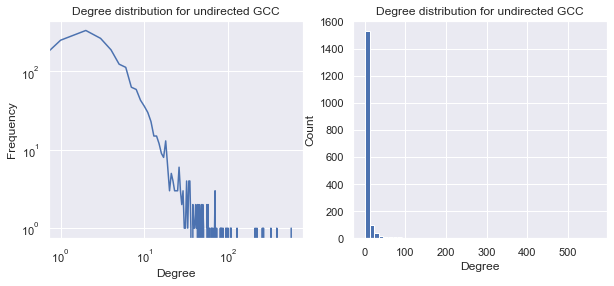

In [13]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
ax[0].loglog(degrees, degree_freq,'-') 
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('Frequency')
ax[0].set_title("Degree distribution for undirected GCC")
degrees = [val for (node, val) in G.degree()]
d1 = np.array(degrees)
ax[1].hist(d1, bins = 50) 
ax[1].set_xlabel('Degree')
ax[1].set_ylabel('Count')
_= ax[1].set_title("Degree distribution for undirected GCC")

The degree distrbibution tells us that the network is not random. This is expected since we have some characters that are in every episode of the show and a lot of characters that only show in a single episode or a few. This gives a very uneven distribution through the network. 

Now we can plot the network using forceatlas2.

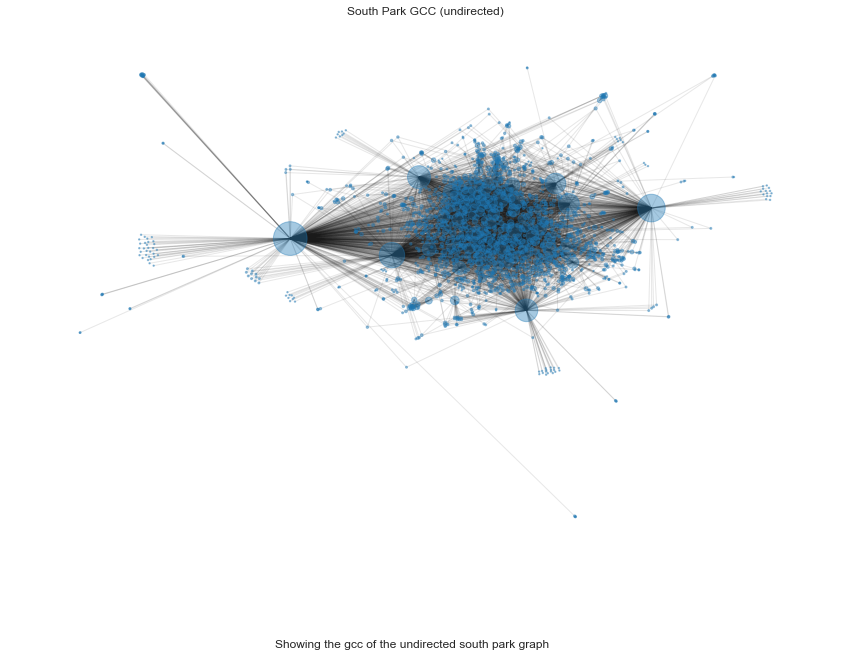

In [14]:
# set node size depending on degree
node_sizes = [2*v for v in dict(G.degree).values()]
# Setup FA2 w. parameters
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,    # Dissuade hubs
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=True,
    gravity=1.0,

    # Log
    verbose=False
)

# compute node positions with the fa algorithm
node_pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
# Plotting the network
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(G, node_pos, node_size=node_sizes, alpha=0.4)
nx.draw_networkx_edges(G, node_pos, alpha=0.1)
plt.title('South Park GCC (undirected)')
plt.axis('off')
fig_text = """Showing the gcc of the undirected south park graph"""
plt.figtext(
    0.5, 0.01, wrap=True, horizontalalignment='center', fontsize=12, s=fig_text
)
plt.savefig("Graph.png", format="PNG")
plt.show()

From this it is clear to see that there are a handfull of hubs that almost all other nodes connect to. This is also what we saw when looking at the degree distribution plot, that there were a few characters that had a lot of nodes connected to them. There are also a lot of nodes with only a few edges, whoch is expected since some characters are only part of 1 or a few episodes. 

### Directed Graph
We will now look at the basic stats for the directed GCC. We are starting by loading it in and getting the basic stats for the graph. 

Starting by loading in the directed gcc

In [15]:
G = nx.read_gpickle("SouthParkDirectedGCC.gpickle")

Printing some basic stats for the network.

In [16]:
def printBasicStats(G):
    print("Basic stats for the gcc network:")
    N = len(G.nodes())
    K = sum(dict(G.degree()).values())/N
    d = log(N)/log(K)
    print("Number of nodes: ", N)
    print("Number of edges: ", len(G.edges()))
    print("Average degree: ", K)
    print("Average distance between 2 nodes: ", d)
    print("\n5 most in degree: " )
    in_deg = sorted(G.in_degree, key=lambda x: x[1], reverse=True)
    for node, degree in in_deg[0:5]:
        print(f'{node}: {degree} edges')
    print("\n5 most out degree: " )
    out_deg = sorted(G.out_degree, key=lambda x: x[1], reverse=True)
    for node, degree in out_deg[0:5]:
        print(f'{node}: {degree} edges')
    
printBasicStats(G)

Basic stats for the gcc network:
Number of nodes:  1708
Number of edges:  7960
Average degree:  9.320843091334895
Average distance between 2 nodes:  3.3343344552628404

5 most in degree: 
Eric Cartman: 555 edges
Stan Marsh: 373 edges
Kyle Broflovski: 321 edges
Butters Stotch: 254 edges
Randy Marsh: 241 edges

5 most out degree: 
Eric Cartman: 95 edges
Heidi Turner: 80 edges
The 4th Grade: 58 edges
Stan Marsh: 51 edges
Randy Marsh: 50 edges


This shows that there are 1172 more edges in the directed graph. Average degree is higher since we can have edges going both ways between nodes. The average distance between 2 nodes are about the same as in the undirected, this is expected.  
The 5 most connected characters in regards to in degree are actually same as in the undirected graph, they are however in a different order. That is the same characters is somewhat expected since they are main characters in the show. The 5 most connected characters in rehard to out degree is a bit more surprising since Heidi turner is in there. She is a main character in the series and is the most popular girl in the 4.th grade, and therefore it makes a bit sense that she has a lot of out degrees. The 4.th grade is mentioned as a character on the wiki page and is therefore also in this list. We could clean it up a bit more and remove all groups from the dataset. 

Lets look at the degree distribution of both in degree and out degree. 

In [17]:
degrees_in = np.array([d for _, d in G.in_degree])
degrees_out = np.array([d for _, d in G.out_degree])
in_deg, in_deg_count = np.unique(degrees_in, return_counts=True)
out_deg, out_deg_count = np.unique(degrees_out, return_counts=True)

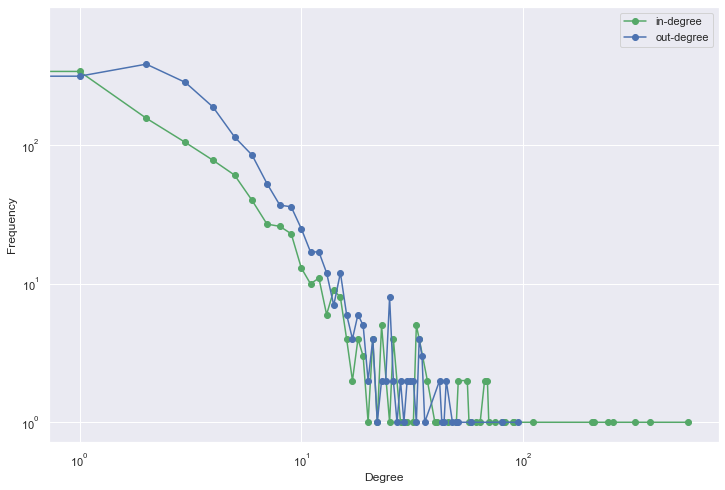

In [18]:
plt.figure(figsize=(12, 8)) 
plt.loglog(in_deg, in_deg_count, 'go-', label='in-degree') 
plt.loglog(out_deg, out_deg_count, 'bo-', label='out-degree')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
_ = plt.show